# Tutorial 3: Integrate MHypo data with MaskGraphene

In this tutorial, we show how to use MG to integrate MHypo data. As an example, we analyze the Bregma -0.04 / Bregma -0.09 sample pair of the mouse hypothalamus dataset. 

We acquired the data from the spatialLIBD webpage, including manual annotations. Before running the model, please download the input data via [zenodo link](https://zenodo.org/records/10698909)

### Loading packages

In [1]:
import logging
import numpy as np
from tqdm import tqdm
import torch
import pickle
import sys
import os
import scanpy as sc
import sklearn.metrics.pairwise

# Get the parent directory of the current script
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the system path
sys.path.insert(0, parent_dir)

from utils import (
    build_args_ST,
    create_optimizer
)
from datasets.st_loading_utils import visualization_umap_spatial, create_dictionary_mnn
from models import build_model_ST

/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = build_args_ST()
args.max_epoch=3000
args.max_epoch_triplet=500
args.section_ids=["-0.19","-0.24"]
args.num_class=8
args.num_hidden="512,32"
args.alpha_l=3
args.lam=1 
args.loss_fn="sce" 
args.mask_rate=0.5 
args.in_drop=0 
args.attn_drop=0 
args.remask_rate=0.5
args.seeds=[2024] 
args.num_remasking=1 
args.dataset="MHypo" 
args.lr=0.0003

#### remember to change these paths to your data path/link path
args.st_data_dir="../../spatial_benchmarking/benchmarking_data/mHypothalamus"
args.hl_dir="../hard_links/MHypo"

### consecutive MHypo pairs

In [3]:
import dgl
import scipy
import anndata
from datasets.data_proc import load_ST_dataset

dataset_name = args.dataset
section_ids = args.section_ids

graph, (num_features, num_cls), ad_concat = load_ST_dataset(dataset_name=dataset_name, section_ids=section_ids, args_=args)
args.num_features = num_features
args.num_class = num_cls
x = graph.ndata["feat"]

/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


------Calculating spatial graph...


/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/data_proc.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/data_proc.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)


The graph contains 40340 edges, 5803 cells.
6.9516 neighbors per cell on average.


/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


------Calculating spatial graph...


/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/data_proc.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/data_proc.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)


The graph contains 36140 edges, 5543 cells.
6.5199 neighbors per cell on average.


### build model

In [4]:
model = build_model_ST(args)
print(model)

device = args.device if args.device >= 0 else "cpu"
model.to(device)

optim_type = args.optimizer 
lr = args.lr
weight_decay = args.weight_decay
optimizer = create_optimizer(optim_type, model, lr, weight_decay)

use_scheduler = args.scheduler
max_epoch = args.max_epoch
max_epoch_triplet = args.max_epoch_triplet
if use_scheduler:
    logging.critical("Use scheduler")
    scheduler = lambda epoch :( 1 + np.cos((epoch) * np.pi / max_epoch) ) * 0.5
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler)
else:
    scheduler = None

model.to(device)
graph = graph.to(device)
x = x.to(device)

=== Use sce_loss and alpha_l=3 ===
num_encoder_params: 97376, num_decoder_params: 97745, num_params_in_total: 230702
PreModel(
  (encoder): GAT(
    (gat_layers): ModuleList(
      (0): GATConv(
        (fc): Linear(in_features=155, out_features=512, bias=False)
        (feat_drop): Dropout(p=0, inplace=False)
        (attn_drop): Dropout(p=0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (activation): ELU(alpha=1.0)
      )
      (1): GATConv(
        (fc): Linear(in_features=512, out_features=32, bias=False)
        (feat_drop): Dropout(p=0, inplace=False)
        (attn_drop): Dropout(p=0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
      )
    )
    (head): Identity()
  )
  (decoder): GAT(
    (gat_layers): ModuleList(
      (0): GATConv(
        (fc): Linear(in_features=32, out_features=512, bias=False)
        (feat_drop): Dropout(p=0, inplace=False)
        (attn_drop): Dropout(p=0, inplace=False)
        (leaky_relu): LeakyReLU

### training

In [5]:
from maskgraphene_main import MG, MG_triplet

model, ad_concat_1 = MG(model, graph, x, optimizer, max_epoch, device, ad_concat, scheduler, logger=None, key_="MG")
model, ad_concat_2 = MG_triplet(model, graph, x, optimizer, max_epoch_triplet, device, adata_concat_=ad_concat_1, scheduler=scheduler, logger=None, key_="MG_triplet")

CRITICAL:root:start training..
100%|██████████| 3000/3000 [00:40<00:00, 73.40it/s]
CRITICAL:root:start training..
# Epoch 499: train_loss: 0.0519: 100%|██████████| 500/500 [00:13<00:00, 36.39it/s]


### evaluate

   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


-0.19 , ARI = 0.601
-0.24 , ARI = 0.588


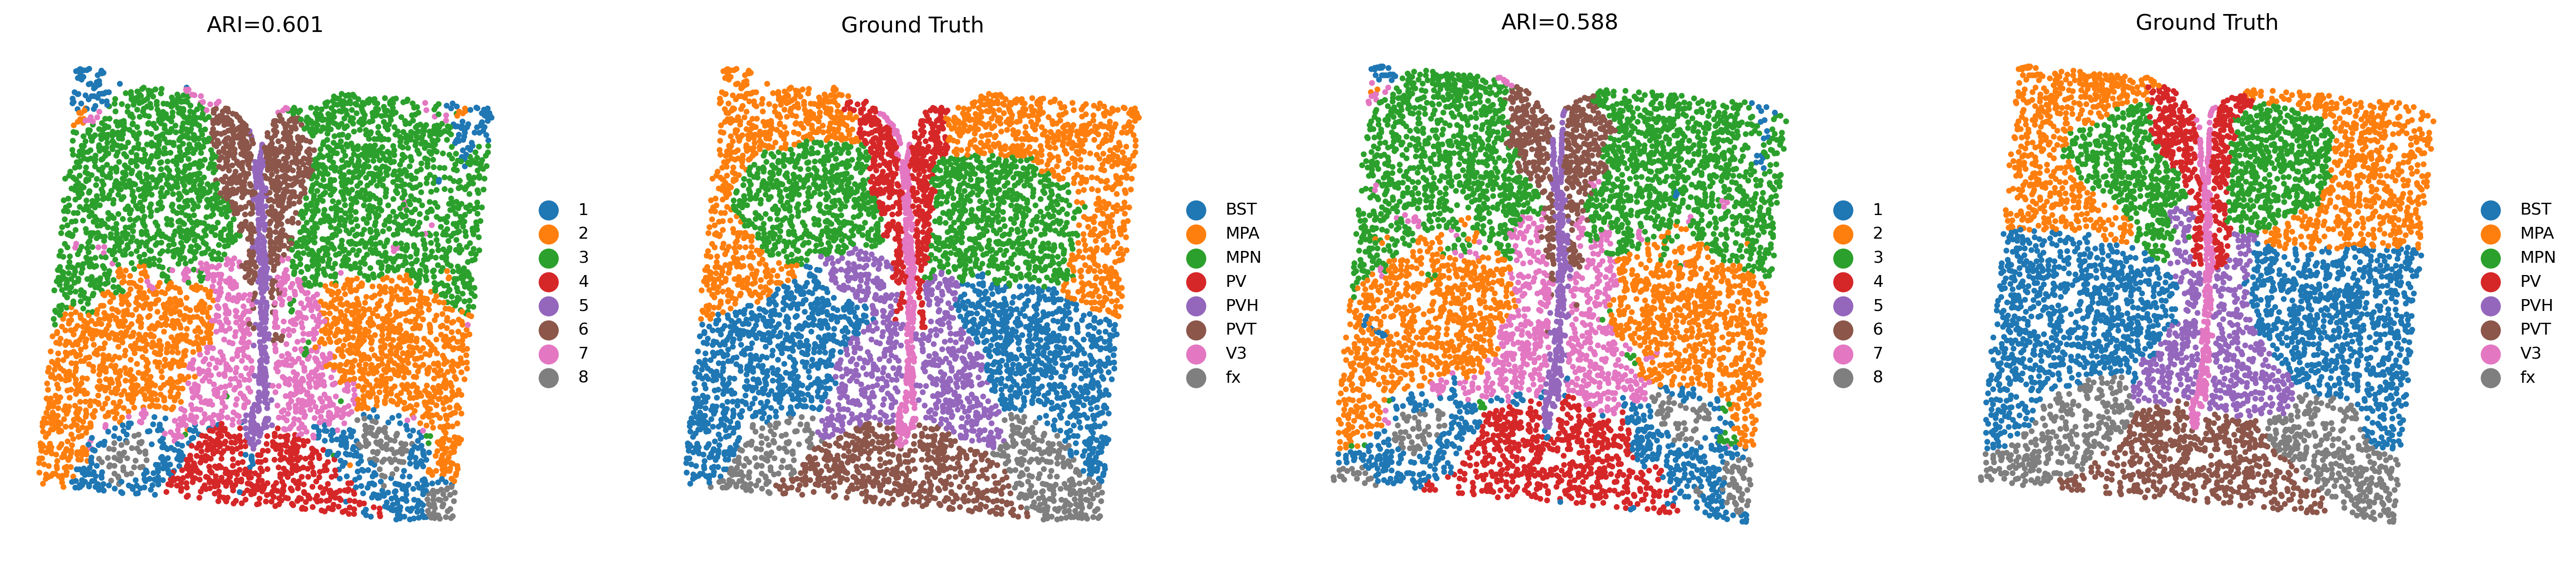

In [6]:
exp_fig_dir = "./temp"
if not os.path.exists(os.path.join(exp_fig_dir, dataset_name+'_'.join(section_ids))):
    os.makedirs(os.path.join(exp_fig_dir, dataset_name+'_'.join(section_ids)))

exp_fig_dir = os.path.join(exp_fig_dir, dataset_name+'_'.join(section_ids))

ari_ = visualization_umap_spatial(ad_temp=ad_concat_2, section_ids=section_ids, exp_fig_dir=exp_fig_dir, dataset_name=dataset_name, num_iter="0", identifier="stage2", num_class=args.num_class, use_key="MG_triplet")
# ari_2.append(ari_[1])
print(section_ids[0], ', ARI = %01.3f' % ari_[0])
print(section_ids[1], ', ARI = %01.3f' % ari_[1])